## preprocess

### check atlas-test_folder <-> csv 

In [ ]:
def list_missing_subfolders_from_csv(input_folder: str, csv_path: str, recursive: bool = False):
    from pathlib import Path
    import csv

    root = Path(input_folder).expanduser().resolve()
    csv_file = Path(csv_path).expanduser().resolve()

    if not root.exists():
        raise FileNotFoundError(f"input_folder not found: {root}")
    if not csv_file.exists():
        raise FileNotFoundError(f"csv not found: {csv_file}")

    # 1) 收集實際存在的 subfolder names
    if recursive:
        actual = {p.name for p in root.rglob("*") if p.is_dir()}
    else:
        actual = {p.name for p in root.iterdir() if p.is_dir()}

    # 2) 讀 CSV 第一欄當作「期望存在的 subfolder 名單」
    expected = set()
    with csv_file.open("r", newline="", encoding="utf-8-sig") as f:
        reader = csv.reader(f)
        first_row = True
        for row in reader:
            if not row:
                continue
            name = str(row[0]).strip()
            if not name:
                continue

            # 如果第一列是 header（常見：name / Name / folder），就跳過
            if first_row and name.lower() in {"name", "folder", "subfolder", "dirname", "dir"}:
                first_row = False
                continue

            expected.add(name)
            first_row = False

    # 3) 找出：名單裡有，但資料夾沒有
    missing_names = sorted(expected - actual)

    detail = {
        "input_folder": str(root),
        "csv_path": str(csv_file),
        "recursive": recursive,
        "n_expected_names": len(expected),
        "n_actual_subfolders": len(actual),
    }
    return missing_names, detail

# @@@@@@@@@@@@@@@@
list_missing_subfolders_from_csv('/mnt/hdd/jeff/dataset/output/mdgen/raw/atlas','/mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv')

### run

python -m scripts.prep_sims --split /mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv --sim_dir /mnt/hdd/jeff/dataset/output/mdgen/raw/atlas --outdir /mnt/hdd/jeff/mdgen-#1/output/test/npy --num_workers 4 --suffix _fit --stride 40 --atlas

### construct R1_npy folder softlink

find /mnt/hdd/jeff/mdgen-#1/output/test/npy -maxdepth 1 -type f -name '*_R1_*' -print0 \
| while IFS= read -r -d '' f; do
    ln -sfn "$f" /mnt/hdd/jeff/dataset/output/mdgen-#1/R1_npy/"$(basename "$f")"
  done

### check npy_folder <-> csv 

In [ ]:
def find_names_in_folder_not_in_csv(
    input_folder: str,
    csv_path: str,
    name_col: str = "name",
    recursive: bool = False,
    file_ext: str = ".npy",
):
    """
    目標：
      input_folder 裡有檔名像 7a7b_B_R1_fit.npy
      取出 name = '7a7b_B'（也就是 _R{num}_ 之前那段）
      檢查這些 name 是否出現在 csv 的 `name_col` 欄位
      回傳：在資料夾裡出現、但不在 CSV 欄位裡的那些 name

    回傳：
      missing_names: list[str]
      detail: dict  (統計與debug資訊)
    """
    from pathlib import Path
    import re

    root = Path(input_folder).expanduser().resolve()
    csv_file = Path(csv_path).expanduser().resolve()

    if not root.exists():
        raise FileNotFoundError(f"input_folder not found: {root}")
    if not csv_file.exists():
        raise FileNotFoundError(f"csv not found: {csv_file}")

    # ---------- 1) 收集資料夾內的 names（從檔名擷取 _R 前的片段） ----------
    # 支援：xxx_R1_yyy.npy、xxx_R12_fit.npy 等
    pat = re.compile(r"^(?P<name>.+?)_R\d+_")

    folder_names = set()
    files_scanned = 0

    def iter_files():
        if recursive:
            yield from root.rglob(f"*{file_ext}")
        else:
            yield from root.glob(f"*{file_ext}")

    for p in iter_files():
        if not p.is_file():
            continue
        files_scanned += 1
        m = pat.match(p.name)
        if m:
            folder_names.add(m.group("name"))

    # ---------- 2) 讀 CSV 的 name 欄位 ----------
    csv_names = set()

    # 先嘗試用 pandas（若環境有）
    try:
        import pandas as pd  # type: ignore
        df = pd.read_csv(csv_file)
        if name_col not in df.columns:
            raise KeyError(f"Column '{name_col}' not found. Available: {list(df.columns)}")
        for v in df[name_col].dropna().astype(str):
            s = v.strip()
            if s:
                csv_names.add(s)
    except ImportError:
        # 沒有 pandas 就用標準庫 csv
        import csv
        with csv_file.open("r", newline="", encoding="utf-8-sig") as f:
            reader = csv.DictReader(f)
            if reader.fieldnames is None or name_col not in reader.fieldnames:
                raise KeyError(f"Column '{name_col}' not found. Available: {reader.fieldnames}")
            for row in reader:
                v = (row.get(name_col) or "").strip()
                if v:
                    csv_names.add(v)

    # ---------- 3) 找出：資料夾有，但 CSV 沒有 ----------
    missing_names = sorted(folder_names - csv_names)

    detail = {
        "input_folder": str(root),
        "csv_path": str(csv_file),
        "recursive": recursive,
        "file_ext": file_ext,
        "files_scanned": files_scanned,
        "n_folder_names": len(folder_names),
        "n_csv_names": len(csv_names),
    }
    return missing_names, detail


# @@@@@@@@@@@@@@@
find_names_in_folder_not_in_csv('/mnt/hdd/jeff/dataset/output/mdgen-#1/R1_npy','/mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv')

## inference

### run

python sim_inference.py --sim_ckpt /mnt/hdd/jeff/dataset/output/mdgen-#1/ckpt/epoch=999-step=111000.ckpt --data_dir /mnt/hdd/jeff/dataset/output/mdgen-#1/test/npy --num_frames 250 --num_rollouts 1 --split /mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv --suffix _R1 --out_dir /mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference --xtc

### big-> new csv

In [18]:
def extract_failed_rows_to_csv(txt_path: str, in_csv_path: str, out_csv_path: str) -> None:
    """
    從 txt 讀出每行開頭的 name（例如 6qj0_A），再到 input CSV 裡把對應的整列(row)撈出來，輸出成新的 CSV。

    txt 範例行：
        6qj0_A\tOutOfMemoryError('...')

    in_csv 欄位範例：
        name,seqres,release_date,msa_id,seqlen
        6qj0_A,MRVTELIIDGFKSY,....

    會輸出只包含 txt 裡出現過的 name 的 rows（保留原本欄位與 header）。
    """
    import csv
    import re

    # --- 1) parse IDs from txt ---
    ids = set()
    # 常見 PDB chain id 形式：4碼(數字/小寫) + "_" + chain
    # 例：6qj0_A、7ec1_A
    pat = re.compile(r"^[0-9a-z]{4}_[A-Za-z0-9]+$")

    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            first = line.split("\t", 1)[0].strip()          # 優先用 tab 切
            first = first.split(None, 1)[0].strip()         # 若不是 tab，就用空白切
            if pat.match(first):
                ids.add(first)

    # --- 2) filter rows from input csv and write output csv ---
    with open(in_csv_path, "r", encoding="utf-8", newline="") as fin:
        reader = csv.DictReader(fin)
        if reader.fieldnames is None:
            raise ValueError("Input CSV 沒有 header，無法用 DictReader 讀取。")

        matched_rows = []
        for row in reader:
            name = (row.get("name") or "").strip()
            if name in ids:
                matched_rows.append(row)

    with open(out_csv_path, "w", encoding="utf-8", newline="") as fout:
        writer = csv.DictWriter(fout, fieldnames=reader.fieldnames)
        writer.writeheader()
        writer.writerows(matched_rows)

    # 可選：印一下結果（不想印就刪掉這行）
    print(f"Parsed {len(ids)} ids from txt – wrote {len(matched_rows)} rows to: {out_csv_path}")

# @@@@@@@@@@@@@@@
txt = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/failed_names.txt'
in_csv = '/mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv'
out_csv = '/mnt/hdd/jeff/mdgen-#1/splits/atlas_test-big.csv'
extract_failed_rows_to_csv(txt,in_csv,out_csv)

Parsed 27 ids from txt – wrote 27 rows to: /mnt/hdd/jeff/mdgen-#1/splits/atlas_test-big.csv


## metrix

### run analyze

mdgen-#1
python -m scripts.analyze_ensembles --atlas_dir /mnt/hdd/jeff/dataset/mdgen-dataset/testset --pdbdir /mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference --num_workers 4

mdgen-#0
python -m scripts.analyze_ensembles --atlas_dir /mnt/hdd/jeff/dataset/mdgen-dataset/testset --pdbdir /mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference --num_workers 8

### check .pkl

In [1]:
import pickle

with open("/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out.pkl", "rb") as f:
    out = pickle.load(f)

print(type(out), len(out))
print(list(out.keys())[:5])          # 看前幾個 name
first = next(iter(out))
print(first, out[first].keys())      # 看某個 name 有哪些欄位


<class 'dict'> 82
['6pce_B', '6l3r_E', '6odd_B', '6e7e_A', '6xrx_A']
6pce_B dict_keys(['ca_mask', 'ref_variance', 'af_variance', 'joint_variance', 'af_rmsf', 'ref_rmsf', 'emd_mean', 'emd_var', 'crystal_sasa', 'ref_sa_prob', 'af_sa_prob', 'ref_mi_mat', 'af_mi_mat', 'ref_contact_prob', 'af_contact_prob', 'crystal_distmat', 'ref_mean_pairwise_rmsd', 'af_mean_pairwise_rmsd', 'ref_rms_pairwise_rmsd', 'af_rms_pairwise_rmsd', 'ref_self_mean_pairwise_rmsd', 'ref_self_rms_pairwise_rmsd', 'cosine_sim', 'EMD,ref', 'EMD,af2', 'EMD,joint'])


In [ ]:
import pickle

pkl = "/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out.pkl"
with open(pkl, "rb") as f:
    data = pickle.load(f)

missing = []
errored = []
for name, d in data.items():
    if not isinstance(d, dict):
        missing.append((name, "not_a_dict"))
        continue
    if "error" in d:
        errored.append((name, d["error"]))
        continue
    if "ref_mean_pairwise_rmsd" not in d:
        missing.append((name, "no_ref_mean_pairwise_rmsd"))
    if "af_mean_pairwise_rmsd" not in d:
        missing.append((name, "no_af_mean_pairwise_rmsd"))

print("n_total:", len(data))
print("n_errored:", len(errored))
print("n_missing_any:", len(missing))

print("\nFirst 10 errored:")
for x in errored[:10]:
    print(x)

print("\nFirst 10 missing:")
for x in missing[:10]:
    print(x)


### 移除沒算成功的

In [3]:
import pickle

inp = "/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out.pkl"
outp = "/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out_clean.pkl"

with open(inp, "rb") as f:
    data = pickle.load(f)

clean = {k: v for k, v in data.items() if isinstance(v, dict) and ("error" not in v)}

print("before:", len(data), "after:", len(clean))

with open(outp, "wb") as f:
    pickle.dump(clean, f)


before: 82 after: 80


### print table

mdgen-#1
python -m scripts.print_analysis /mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out_clean.pkl

mdgen-#0
python -m scripts.print_analysis /mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out_clean.pkl

## metrix-ppt

### pairwise RMSD r

In [ ]:
def plot_pairwise_rmsd_scatter(pkl_path: str, out_png: str = "pairwise_rmsd_scatter.png",
                              annotate: bool = True, dpi: int = 200):
    """
    從 analyze_ensembles.py 產生的 out.pkl 畫 scatter：
      x: ref_mean_pairwise_rmsd
      y: af_mean_pairwise_rmsd
    每個點 = 1 個 protein (name)

    會輸出：
      1) 圖檔 out_png
      2) 回傳 (r, n_points, points_dict)
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    # --- load pkl ---
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)  # dict: name -> metrics dict

    # --- extract points ---
    names, xs, ys = [], [], []
    for name, d in data.items():
        if not isinstance(d, dict):
            continue
        if "error" in d:
            continue
        if ("ref_mean_pairwise_rmsd" not in d) or ("af_mean_pairwise_rmsd" not in d):
            continue
        x = d["ref_mean_pairwise_rmsd"]
        y = d["af_mean_pairwise_rmsd"]
        if x is None or y is None:
            continue
        try:
            x = float(x)
            y = float(y)
        except Exception:
            continue
        if not (np.isfinite(x) and np.isfinite(y)):
            continue
        names.append(name)
        xs.append(x)
        ys.append(y)

    xs = np.array(xs, dtype=float)
    ys = np.array(ys, dtype=float)
    n = len(xs)
    if n < 2:
        raise ValueError(f"Not enough valid points to compute correlation (n={n}).")

    # --- pearson r (no scipy dependency) ---
    r = float(np.corrcoef(xs, ys)[0, 1])

    # --- plot ---
    plt.figure()
    plt.scatter(xs, ys)
    plt.xlabel("MD pairwise RMSD (ref_mean_pairwise_rmsd)")
    plt.ylabel("Generated pairwise RMSD (af_mean_pairwise_rmsd)")
    plt.title(f"Pairwise RMSD scatter (n={n}, Pearson r={r:.3f})")

    # if annotate:
    #     for name, x, y in zip(names, xs, ys):
    #         plt.annotate(name, (x, y), fontsize=7)

    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.show()
    plt.close()

    points = {name: {"x_ref_mean_pairwise_rmsd": float(x), "y_af_mean_pairwise_rmsd": float(y)}
              for name, x, y in zip(names, xs, ys)}
    return r, n, points


# @@@@@@@@@@@@@@@
# mdgen-#1
pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/ppt-metrix/pairwise_rmsd_r.png'
plot_pairwise_rmsd_scatter(pkl,png)

# mdgen-#0
pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/ppt-metrix/pairwise_rmsd_r.png'
plot_pairwise_rmsd_scatter(pkl,png)

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_pairwise_rmsd_scatter_comparison(pkl_path1: str, pkl_path2: str, 
                                         label1: str = "Model 1", label2: str = "Model 2",
                                         out_png: str = "pairwise_rmsd_comparison.png",
                                         dpi: int = 200):
    """
    比較兩個模型的 Pairwise RMSD 預測。
    如果同一個蛋白 (protein name) 同時存在於兩個檔案中，會用淺色線連起來。
    """
    
    def load_to_dict(pkl_path):
        with open(pkl_path, "rb") as f:
            data = pickle.load(f)
        
        result_dict = {}
        for name, d in data.items():
            if not isinstance(d, dict) or "error" in d:
                continue
            if "ref_mean_pairwise_rmsd" in d and "af_mean_pairwise_rmsd" in d:
                try:
                    x = float(d["ref_mean_pairwise_rmsd"])
                    y = float(d["af_mean_pairwise_rmsd"])
                    if np.isfinite(x) and np.isfinite(y):
                        result_dict[name] = (x, y)
                except:
                    continue
        return result_dict

    # 1. 讀取資料為字典方便對比
    dict1 = load_to_dict(pkl_path1)
    dict2 = load_to_dict(pkl_path2)

    # 2. 提取繪圖座標
    names1 = list(dict1.keys())
    x1 = np.array([dict1[n][0] for n in names1])
    y1 = np.array([dict1[n][1] for n in names1])
    
    names2 = list(dict2.keys())
    x2 = np.array([dict2[n][0] for n in names2])
    y2 = np.array([dict2[n][1] for n in names2])

    # 3. 計算相關係數
    r1 = np.corrcoef(x1, y1)[0, 1] if len(x1) > 1 else 0
    r2 = np.corrcoef(x2, y2)[0, 1] if len(x2) > 1 else 0

    # 4. 開始繪圖
    plt.figure(figsize=(8, 7))
    
    # --- 繪製連線 (由背景層開始，才不會遮住點) ---
    common_names = set(dict1.keys()) & set(dict2.keys())
    line_label_added = False
    for name in common_names:
        p1 = dict1[name]
        p2 = dict2[name]
        # 使用 zorder=1 放在最底層，alpha 設淡一點
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', 
                 alpha=0.2, linewidth=0.8, zorder=1)
    
    # --- 繪製散點 (zorder=2 確保在線上面) ---
    plt.scatter(x1, y1, color='tab:blue', alpha=0.7, edgecolors='none', 
                s=40, label=f"{label1} (r={r1:.3f})", zorder=2)
    plt.scatter(x2, y2, color='tab:orange', alpha=0.7, edgecolors='none', 
                s=40, label=f"{label2} (r={r2:.3f})", zorder=2)

    # 5. 繪製 y=x 參考線 
    max_val = max(x1.max(), x2.max(), y1.max(), y2.max()) * 1.05
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label="Perfect correlation")

    # 6. 圖表修飾
    plt.xlabel("MD Reference Pairwise RMSD (Ref)")
    plt.ylabel("Generated Ensemble Pairwise RMSD (Model)")
    plt.title("Pairwise RMSD Comparison Between Two Models")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    # plt.show() # 如果在 notebook 環境可以開啟
    plt.close()

    return r1, r2, len(common_names)
pkl1 = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out_clean.pkl'
pkl2 = '/mnt/hdd/jeff/dataset/output/mdgen-#2/test/inference/out_clean.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-ppt/pairwise_rmsd_#1#2.png'
plot_pairwise_rmsd_scatter_comparison(pkl_path1=pkl1, pkl_path2=pkl2, 
                                   label1="#1", label2="#2",
                                   out_png=png,
                                   dpi=200)

(0.49062122963424354, 0.4251078729773534, 80)

### global rmsf r

In [ ]:
### single

def plot_global_rmsf_scatter(
    pkl_path: str,
    out_png: str = "global_rmsf_scatter.png",
    max_points: int = 30000,
    seed: int = 0,
    dpi: int = 200,
):
    """
    依照 Table 4 的「Global RMSF r」概念畫 scatter + 算 Pearson r：

    - x 軸：reference RMSF（out[name]['ref_rmsf']）
    - y 軸：generated RMSF（out[name]['af_rmsf']）
    - 每個點：一個 residue/atom 的 RMSF（把所有 proteins 的 RMSF 向量串在一起 = global）

    使用的 pkl key：
      - ref_rmsf, af_rmsf  (必要)
      - ca_mask            (可選；若存在就只取 mask=True 的位置)

    會輸出：
      - out_png 圖檔
    回傳：
      - r (float): global Pearson correlation
      - n_points (int): 實際畫進去/計算的點數
      - stats (dict): 每個 protein 貢獻了多少點等資訊
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- load ----
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)  # dict: name -> metrics dict

    # ---- collect global points (concat across proteins) ----
    xs_list, ys_list = [], []
    per_protein_n = {}
    skipped = []

    for name, d in data.items():
        if not isinstance(d, dict) or ("error" in d):
            skipped.append(name)
            continue
        if ("ref_rmsf" not in d) or ("af_rmsf" not in d):
            skipped.append(name)
            continue

        ref = np.asarray(d["ref_rmsf"], dtype=float).reshape(-1)
        af = np.asarray(d["af_rmsf"], dtype=float).reshape(-1)

        if ref.shape[0] != af.shape[0]:
            skipped.append(name)
            continue

        # optional mask (often CA mask / valid positions)
        if "ca_mask" in d and d["ca_mask"] is not None:
            mask = np.asarray(d["ca_mask"]).astype(bool).reshape(-1)
            if mask.shape[0] == ref.shape[0]:
                ref = ref[mask]
                af = af[mask]

        good = np.isfinite(ref) & np.isfinite(af)
        ref = ref[good]
        af = af[good]

        if ref.size == 0:
            skipped.append(name)
            continue

        xs_list.append(ref)
        ys_list.append(af)
        per_protein_n[name] = int(ref.size)

    if len(xs_list) == 0:
        raise ValueError("No valid proteins/points found in pkl (all skipped).")

    x = np.concatenate(xs_list, axis=0)
    y = np.concatenate(ys_list, axis=0)

    n_total = int(x.size)
    if n_total < 2:
        raise ValueError(f"Not enough points to compute correlation (n={n_total}).")

    # ---- downsample for plotting if too many points (still compute r on sampled points here) ----
    # 如果你想「r 用全部點」但「圖只抽樣」，我也可以幫你改成兩套（r 全量 / plot 抽樣）。
    if max_points is not None and n_total > max_points:
        rng = np.random.default_rng(seed)
        idx = rng.choice(n_total, size=max_points, replace=False)
        x_plot = x[idx]
        y_plot = y[idx]
    else:
        x_plot = x
        y_plot = y

    # Pearson r（不用 scipy）
    r = float(np.corrcoef(x_plot, y_plot)[0, 1])

    # ---- plot ----
    plt.figure()
    plt.scatter(x_plot, y_plot, s=8)
    plt.xlabel("Reference RMSF (ref_rmsf)")
    plt.ylabel("Generated RMSF (af_rmsf)")
    plt.title(f"Global RMSF scatter (points={x_plot.size}, Pearson r={r:.3f})")
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.show()
    plt.close()

    stats = {
        "n_proteins_total_in_pkl": len(data),
        "n_proteins_used": len(per_protein_n),
        "n_proteins_skipped": len(skipped),
        "n_points_total_before_sampling": n_total,
        "n_points_used_for_plot_and_r": int(x_plot.size),
        "per_protein_points": per_protein_n,
        "skipped_names": skipped,
    }
    return r, int(x_plot.size), stats

# @@@@@@@@@@@@@@@
# mdgen-#1
pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/ppt-metrix/global_rmsf_r.png'
plot_global_rmsf_scatter(pkl,png)

# mdgen-#0
pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/ppt-metrix/global_rmsf_r.png'
plot_global_rmsf_scatter(pkl,png)

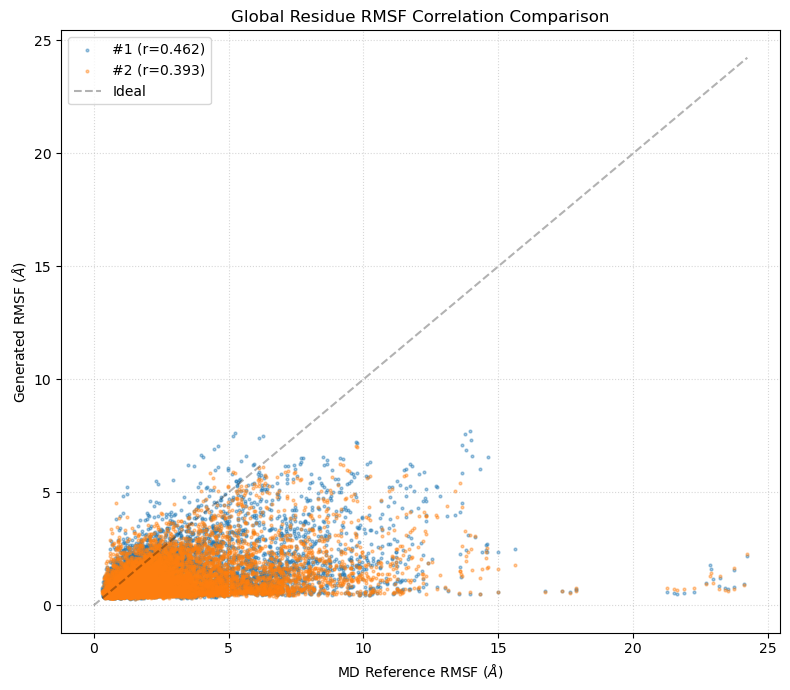

{'r1': 0.4623224995904411, 'r2': 0.39321559511729803, 'n1': 10879, 'n2': 10879}

In [8]:
### 2 pkl comparison
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_global_rmsf_scatter_comparison(
    pkl_path1: str,
    pkl_path2: str,
    label1: str = "Model 1",
    label2: str = "Model 2",
    out_png: str = "global_rmsf_comparison.png",
    max_points: int = 15000,  # 每一組繪圖點數上限，避免圖檔過大
    seed: int = 0,
    dpi: int = 200,
):
    """
    比較兩個模型的 Global RMSF 表現。
    x 軸：MD 基準 (ref_rmsf)
    y 軸：生成模型 (af_rmsf)
    """
    
    def collect_global_data(pkl_path):
        with open(pkl_path, "rb") as f:
            data = pickle.load(f)
        
        all_ref, all_gen = [], []
        for name, d in data.items():
            if not isinstance(d, dict) or "error" in d:
                continue
            if "ref_rmsf" not in d or "af_rmsf" not in d:
                continue
            
            # 取得原始數據
            ref = np.asarray(d["ref_rmsf"]).flatten()
            gen = np.asarray(d["af_rmsf"]).flatten()
            
            # 處理 ca_mask (僅保留 C-alpha 殘基的 RMSF)
            if "ca_mask" in d and d["ca_mask"] is not None:
                mask = np.asarray(d["ca_mask"]).astype(bool).flatten()
                if mask.shape == ref.shape:
                    ref, gen = ref[mask], gen[mask]
            
            good = np.isfinite(ref) & np.isfinite(gen)
            all_ref.append(ref[good])
            all_gen.append(gen[good])
            
        return np.concatenate(all_ref), np.concatenate(all_gen)

    # 1. 收集數據
    ref1, gen1 = collect_global_data(pkl_path1)
    ref2, gen2 = collect_global_data(pkl_path2)

    # 2. 計算 Pearson r (基於完整數據)
    r1 = np.corrcoef(ref1, gen1)[0, 1]
    r2 = np.corrcoef(ref2, gen2)[0, 1]

    # 3. 抽樣繪圖 (Downsampling for visualization)
    def downsample(x, y):
        if max_points is not None and len(x) > max_points:
            rng = np.random.default_rng(seed)
            idx = rng.choice(len(x), size=max_points, replace=False)
            return x[idx], y[idx]
        return x, y

    plt_ref1, plt_gen1 = downsample(ref1, gen1)
    plt_ref2, plt_gen2 = downsample(ref2, gen2)

    # 4. 繪圖
    plt.figure(figsize=(8, 7))
    
    # 繪製兩組數據
    plt.scatter(plt_ref1, plt_gen1, s=4, alpha=0.4, label=f"{label1} (r={r1:.3f})", color='tab:blue')
    plt.scatter(plt_ref2, plt_gen2, s=4, alpha=0.4, label=f"{label2} (r={r2:.3f})", color='tab:orange')

    # 繪製 y=x 參考線
    max_val = max(plt_ref1.max(), plt_ref2.max(), plt_gen1.max(), plt_gen2.max())
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label="Ideal")

    plt.xlabel("MD Reference RMSF ($\AA$)")
    plt.ylabel("Generated RMSF ($\AA$)")
    plt.title("Global Residue RMSF Correlation Comparison")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.show()
    plt.close()

    return {"r1": r1, "r2": r2, "n1": len(ref1), "n2": len(ref2)}


# @@@@@@@@@@@@@@@
pkl1 = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out_clean.pkl'
pkl2 = '/mnt/hdd/jeff/dataset/output/mdgen-#2/test/inference/out_clean.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-ppt/global_rmsf_#1#2.png'
plot_global_rmsf_scatter_comparison(
    pkl_path1=pkl1,
    pkl_path2=pkl2,
    label1="#1",
    label2="#2",
    out_png=png,
    max_points=15000,  # 每一組繪圖點數上限，避免圖檔過大
    seed=0,
    dpi=200,
)

### per-target RMSF r

In [ ]:
### single 
def per_target_rmsf_r_from_pkl(
    pkl_path,
    out_png,
    use_mask: bool = True,
    min_len: int = 3,
    dpi: int = 200,
):
    """
    Per-target RMSF r（Table 4 的概念）：
      - 每個 protein（每個 name）各自計算一次 Pearson r：
          r_i = corr( ref_rmsf_i , af_rmsf_i )
      - 最後你可以對 {r_i} 取 median / mean 等作為 summary

    使用的 pkl key：
      - ref_rmsf, af_rmsf (必要)
      - ca_mask          (可選；use_mask=True 時會套用)

    輸出：
      - out_csv：每個 protein 的 r、點數 n 等
      - out_png：r 的分佈直方圖（每個 protein 一個 r）
    回傳：
      - r_per_target: dict[name] = r
      - summary: dict (median, mean, n_used, n_skipped...)
    """
    import pickle
    import numpy as np
    import csv
    import matplotlib.pyplot as plt

    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    r_dict = {}
    n_dict = {}
    skipped = {}

    def pearsonr_np(a: np.ndarray, b: np.ndarray) -> float:
        # a, b 為 1D，已確保長度>=2且finite
        if a.size < 2:
            return float("nan")
        return float(np.corrcoef(a, b)[0, 1])

    for name, d in data.items():
        if not isinstance(d, dict) or ("error" in d):
            skipped[name] = "error_in_entry"
            continue
        if ("ref_rmsf" not in d) or ("af_rmsf" not in d):
            skipped[name] = "missing_ref_or_af_rmsf"
            continue

        ref = np.asarray(d["ref_rmsf"], dtype=float).reshape(-1)
        af = np.asarray(d["af_rmsf"], dtype=float).reshape(-1)

        if ref.shape[0] != af.shape[0]:
            skipped[name] = f"length_mismatch ref={ref.shape[0]} af={af.shape[0]}"
            continue

        if use_mask and ("ca_mask" in d) and (d["ca_mask"] is not None):
            mask = np.asarray(d["ca_mask"]).astype(bool).reshape(-1)
            if mask.shape[0] == ref.shape[0]:
                ref = ref[mask]
                af = af[mask]

        good = np.isfinite(ref) & np.isfinite(af)
        ref = ref[good]
        af = af[good]

        if ref.size < min_len:
            skipped[name] = f"too_few_points n={ref.size}"
            continue

        r = pearsonr_np(ref, af)
        if not np.isfinite(r):
            skipped[name] = "non_finite_r"
            continue

        r_dict[name] = r
        n_dict[name] = int(ref.size)

    if len(r_dict) == 0:
        raise ValueError("No valid per-target RMSF correlations could be computed.")

    # ---- summary ----
    r_vals = np.array(list(r_dict.values()), dtype=float)
    summary = {
        "n_targets_used": int(r_vals.size),
        "n_targets_skipped": int(len(skipped)),
        "median_r": float(np.median(r_vals)),
        "mean_r": float(np.mean(r_vals)),
        "min_r": float(np.min(r_vals)),
        "max_r": float(np.max(r_vals)),
    }


    # ---- plot histogram ----
    plt.figure()
    plt.hist(r_vals, bins=30)
    plt.xlabel("Per-target RMSF Pearson r")
    plt.ylabel("Count (proteins)")
    plt.title(f"Per-target RMSF r distribution (n={r_vals.size}, median={summary['median_r']:.3f})")
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.show()
    plt.close()

    return r_dict, summary

# @@@@@@@@@@@@@@@
# mdgen-#1
pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/ppt-metrix/per_target_rmsf_r_hist.png'
per_target_rmsf_r_from_pkl(pkl,png)

# mdgen-#0
pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/ppt-metrix/per_target_rmsf_r_hist.png'
per_target_rmsf_r_from_pkl(pkl,png)

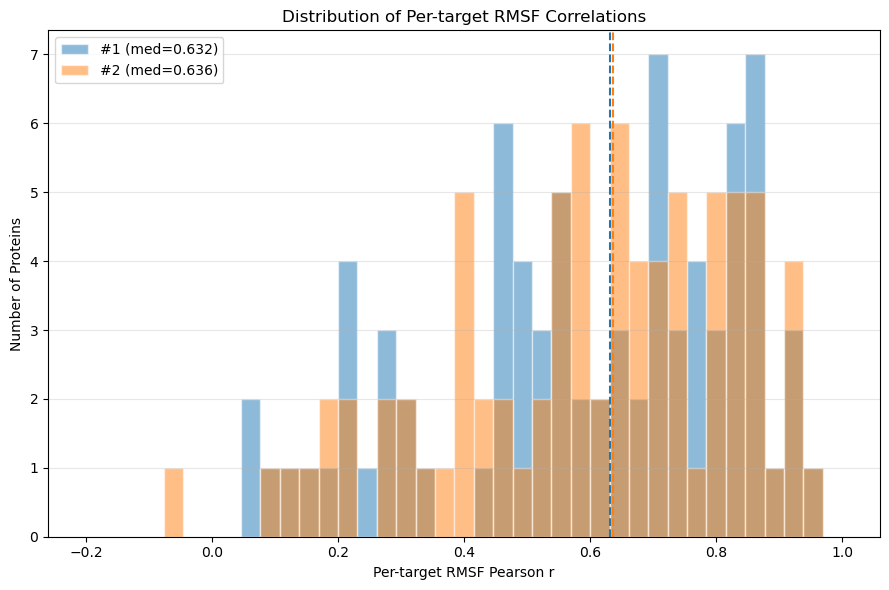

{'label1': {'median': 0.6319684194082928, 'count': 80},
 'label2': {'median': 0.635917733424499, 'count': 80}}

In [11]:
### 2 pkl comparison

import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_per_target_rmsf_r_comparison(
    pkl_path1: str,
    pkl_path2: str,
    label1: str = "Model 1",
    label2: str = "Model 2",
    out_png: str = "per_target_rmsf_comparison.png",
    use_mask: bool = True,
    min_len: int = 5,
    dpi: int = 200,
):
    """
    比較兩個模型的 Per-target RMSF r 分佈（Table 4 的指標）。
    每個蛋白質計算一個相關係數 r，最後繪製直方圖對比。
    """
    
    def get_per_target_r(pkl_path):
        with open(pkl_path, "rb") as f:
            data = pickle.load(f)
        
        r_list = []
        for name, d in data.items():
            if not isinstance(d, dict) or "error" in d:
                continue
            if "ref_rmsf" not in d or "af_rmsf" not in d:
                continue
            
            ref = np.asarray(d["ref_rmsf"]).flatten()
            gen = np.asarray(d["af_rmsf"]).flatten()
            
            # 套用 mask 確保只計算特定的原子（如 C-alpha）
            if use_mask and "ca_mask" in d and d["ca_mask"] is not None:
                mask = np.asarray(d["ca_mask"]).astype(bool).flatten()
                if mask.shape == ref.shape:
                    ref, gen = ref[mask], gen[mask]
            
            good = np.isfinite(ref) & np.isfinite(gen)
            ref, gen = ref[good], gen[good]
            
            if len(ref) >= min_len:
                # 計算該蛋白內部的相關性
                r = np.corrcoef(ref, gen)[0, 1]
                if np.isfinite(r):
                    r_list.append(r)
        return np.array(r_list)

    # 1. 取得兩組數據的相關係數列表
    rs1 = get_per_target_r(pkl_path1)
    rs2 = get_per_target_r(pkl_path2)

    if rs1.size == 0 or rs2.size == 0:
        raise ValueError("無效的資料點，無法計算相關係數分布。")

    # 2. 計算總結統計（Median 是 Table 4 的呈現方式） 
    med1 = np.median(rs1)
    med2 = np.median(rs2)

    # 3. 繪製直方圖對比 [cite: 141, 142]
    plt.figure(figsize=(9, 6))
    
    # 使用透明度 alpha 讓重疊部分可見
    bins = np.linspace(-0.2, 1.0, 40) # 相關係數通常在 0~1 之間
    plt.hist(rs1, bins=bins, alpha=0.5, label=f"{label1} (med={med1:.3f})", color='tab:blue', edgecolor='white')
    plt.hist(rs2, bins=bins, alpha=0.5, label=f"{label2} (med={med2:.3f})", color='tab:orange', edgecolor='white')

    plt.axvline(med1, color='tab:blue', linestyle='--', linewidth=1.5)
    plt.axvline(med2, color='tab:orange', linestyle='--', linewidth=1.5)

    plt.xlabel("Per-target RMSF Pearson r")
    plt.ylabel("Number of Proteins")
    plt.title(f"Distribution of Per-target RMSF Correlations")
    plt.legend(loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.show()
    plt.close()

    return {
        "label1": {"median": med1, "count": rs1.size},
        "label2": {"median": med2, "count": rs2.size}
    }


pkl1 = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/out_clean.pkl'
pkl2 = '/mnt/hdd/jeff/dataset/output/mdgen-#2/test/inference/out_clean.pkl'
png = '/mnt/hdd/jeff/dataset/output/mdgen-ppt/per_target_rmsf_#1#2.png'
plot_per_target_rmsf_r_comparison(
    pkl_path1=pkl1,
    pkl_path2=pkl2,
    label1= "#1",
    label2= "#2",
    out_png= png
)

### root mean w2 dist

In [ ]:
### for a protein
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_overlay_pca_distribution(af_pdb, af_xtc, mdgen_pdb, mdgen_xtc, label,out_png="pca_overlay_comparison.png"):
    print("正在讀取軌跡資料...")
    # 1. 讀取 AF 與 MDGEN 軌跡 [cite: 3]
    af_traj = md.load(af_xtc, top=af_pdb)
    mdgen_traj = md.load(mdgen_xtc, top=mdgen_pdb)

    # 2. 預處理：只保留 C-alpha 原子並進行結構對齊 (Alignment) [cite: 3]
    af_ca = af_traj.atom_slice(af_traj.top.select("name CA"))
    mdgen_ca = mdgen_traj.atom_slice(mdgen_traj.top.select("name CA"))
    
    # 以 AF 的第一個 frame 作為基準進行對齊，確保座標系一致 [cite: 3]
    af_ca.superpose(af_ca[0])
    mdgen_ca.superpose(af_ca[0])

    # 3. 準備數據
    # AF：隨機挑選 250 個 frames [cite: 3]
    n_af = af_ca.n_frames
    af_indices = np.random.choice(n_af, size=min(250, n_af), replace=False)
    af_sampled_xyz = af_ca.xyz[af_indices].reshape(len(af_indices), -1)
    
    # MDGEN：使用全部 frames [cite: 3]
    mdgen_xyz = mdgen_ca.xyz.reshape(mdgen_ca.n_frames, -1)

    # 4. 計算 PCA：核心步驟——完全使用 AF 數據來 fit PCA 模型 [cite: 3]
    print("計算 PCA (僅使用 AF 作為基準)...")
    pca = PCA(n_components=2)
    pca.fit(af_sampled_xyz) 
    
    # 將兩組數據都投影到相同的 AF PC 軸上 [cite: 3]
    af_pca_proj = pca.transform(af_sampled_xyz)
    mdgen_pca_proj = pca.transform(mdgen_xyz)

    # 5. 繪圖：將兩者疊加在同一張圖上
    plt.figure(figsize=(10, 8))
    
    # 繪製 MDGEN 分佈 (作為背景，通常點數較多，設定較低透明度)
    plt.scatter(mdgen_pca_proj[:, 0], mdgen_pca_proj[:, 1], 
                c='tab:red', alpha=0.15, s=10, label=label, zorder=1)
    
    # 繪製 AF 分佈 (疊加在上方)
    plt.scatter(af_pca_proj[:, 0], af_pca_proj[:, 1], 
                c='tab:blue', alpha=0.6, s=25, label='ATLAS', zorder=2)

    # 標註 PCA 的解釋變異量 [cite: 3]
    expl_var = pca.explained_variance_ratio_
    plt.xlabel(f"PC1 ({expl_var[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")
    
    plt.title(f"MD PCA W2 dist.")
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.5)
    
    # 保持比例一致
    plt.gca().set_aspect('equal', adjustable='datalim')

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    print(f"疊加圖表已儲存至 {out_png}")
    plt.show()
    plt.close()


af_pdb = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6d7y_A/6d7y_A.pdb'
af_xtc = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6d7y_A/6d7y_A_prod_R1_fit.xtc'
mdgen_pdb = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/6d7y_A.pdb'
mdgen_xtc = '/mnt/hdd/jeff/dataset/output/mdgen-#1/test/inference/6d7y_A.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/mdgen-ppt/6d7y_mdpcaw2dist_#1.png'
plot_overlay_pca_distribution(af_pdb, af_xtc, mdgen_pdb, mdgen_xtc, '#1',out_png=out_png)

分佈圖已儲存至: /mnt/hdd/jeff/dataset/output/mdgen-ppt/w2_distribution_#0.png


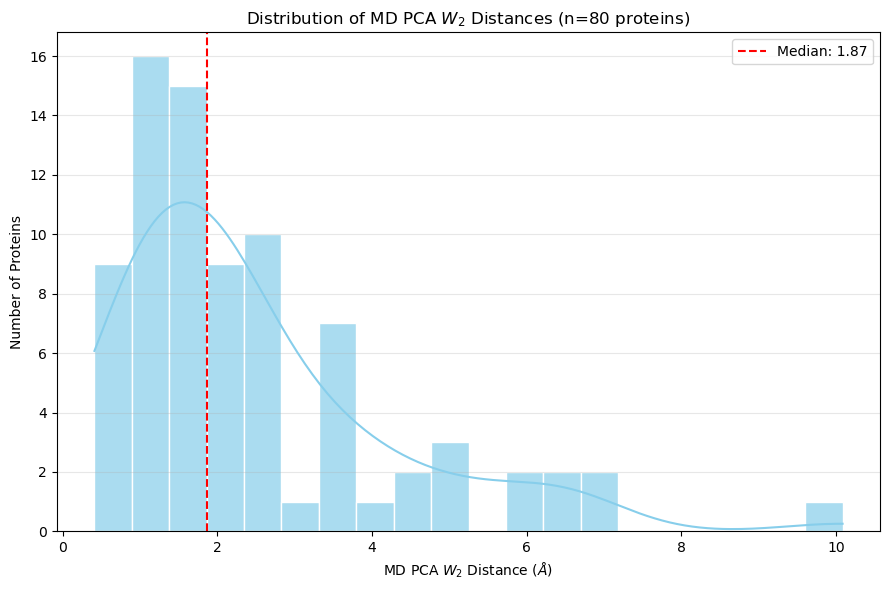

In [28]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_w2_distribution(pkl_path, label="Model", out_png="w2_distribution.png", dpi=200):
    """
    從 pkl 中提取所有蛋白的 MD PCA W2 並畫出分佈圖。
    """
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    w2_values = []
    for name, d in data.items():
        if not isinstance(d, dict) or "error" in d:
            continue
        try:
            # 提取 MD PCA W2 (ref|af)
            val = d['EMD,ref']['ref|af']
            if np.isfinite(val):
                w2_values.append(val)
        except (KeyError, TypeError):
            continue

    w2_values = np.array(w2_values)
    median_val = np.median(w2_values)
    n_proteins = len(w2_values)

    if n_proteins == 0:
        print("找不到有效數據。")
        return

    # --- 繪圖 ---
    plt.figure(figsize=(9, 6))
    
    # 畫直方圖與密度曲線
    sns.histplot(w2_values, kde=True, color="skyblue", bins=20, edgecolor="white", alpha=0.7)
    
    # 標註中位數 (Table 4 的指標)
    plt.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}')
    
    plt.title(f"Distribution of MD PCA $W_2$ Distances (n={n_proteins} proteins)")
    plt.xlabel("MD PCA $W_2$ Distance ($\AA$)")
    plt.ylabel("Number of Proteins")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    print(f"分佈圖已儲存至: {out_png}")
    plt.show()

pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out_clean.pkl'
out_png = '/mnt/hdd/jeff/dataset/output/mdgen-ppt/w2_distribution_#0.png'
plot_w2_distribution(pkl, label="#0", out_png=out_png)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residue_length_distribution(atlas_path, train_path):
    # 1. 讀取 CSV 檔案
    # ATLAS.csv 裡面長度在 'Len.' 欄位
    atlas_df = pd.read_csv(atlas_path)
    # train.csv 裡面需要計算 'seqres' 欄位的字串長度
    train_df = pd.read_csv(train_path)
    
    # 2. 提取長度數據
    # 確保 ATLAS 的 Len 欄位是數值，並去除缺失值
    atlas_lengths = pd.to_numeric(atlas_df['Len.'], errors='coerce').dropna()
    
    # 計算 train.csv 中序列的長度
    train_lengths = train_df['seqres'].str.len().dropna()
    
    # 3. 繪圖
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # 畫出 ATLAS 的分佈 (藍色)
    sns.histplot(atlas_lengths, color="skyblue", label='ATLAS (Len.)', 
                 kde=True, stat="density", alpha=0.5)
    
    # 畫出 train 的分佈 (橘色)
    sns.histplot(train_lengths, color="orange", label='train (seqres length)', 
                 kde=True, stat="density", alpha=0.5)
    
    # 設定圖表資訊
    plt.title('Residue Length Distribution: ATLAS vs train', fontsize=15)
    plt.xlabel('Residue Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    # 保存或顯示
    plt.savefig('length_distribution.png')
    # plt.show()

# 使用範例
# plot_residue_length_distribution('ATLAS.csv', 'train.csv')

### w2 v.s. residue length